In [1]:
import os
import numpy as np
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
NUM_OF_PARTICIPANTS = 43
NUM_OF_SESSIONS = 3
GESTURE_IDS = [8, 9, 10, 15, 16]  # selected gestures
GESTURE_MAP = {g: i for i, g in enumerate(GESTURE_IDS)}  # {8:0, 9:1,...}
NUM_CLASSES = len(GESTURE_IDS)

FS = 2048
WINDOW_SIZE = int(0.6 * FS)   # 1229
STEP_SIZE = WINDOW_SIZE // 2
BATCH_SIZE = 64
STEPS_PER_EPOCH = 75       # prototype (fast) — recommended: 500–1000 for final training
VALIDATION_STEPS = 15      # prototype — recommended: 100–200 for final training
EPOCHS = 6                 # prototype — recommended: 30–40 for final training
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

converted_root = r".\Processed_data"

In [3]:
participants = np.arange(1, NUM_OF_PARTICIPANTS + 1)

# 70% train, 15% validation, 15% test dataset split (at participant level) 
train_subj, temp_subj = train_test_split(participants, test_size=0.3, random_state=RANDOM_SEED)
val_subj, test_subj = train_test_split(temp_subj, test_size=0.5, random_state=RANDOM_SEED)

def build_file_list(subj_list):
    files = []
    for sessionNum in range(1, NUM_OF_SESSIONS + 1):
        sessionFolder = f"Session{sessionNum}_Converted"
        sessionPath = os.path.join(converted_root, sessionFolder)
        for pid in subj_list:
            f = os.path.join(sessionPath, f"session{sessionNum}_participant{pid}.npz")
            if os.path.exists(f):
                files.append(f)
    return files

train_files = build_file_list(train_subj)
val_files   = build_file_list(val_subj)
test_files  = build_file_list(test_subj)

print(f"Train:{len(train_subj)} Val:{len(val_subj)} Test:{len(test_subj)} participants")

Train:30 Val:6 Test:7 participants


In [4]:
def sliding_windows_from_trial(trial_signal, window_size=WINDOW_SIZE, step=STEP_SIZE):
    n = trial_signal.shape[0]
    for start in range(0, n - window_size + 1, step):
        end = start + window_size
        yield trial_signal[start:end, :]

def normalize_window(win):
    mean = np.mean(win, axis=0, keepdims=True)
    std = np.std(win, axis=0, keepdims=True) + 1e-8
    return ((win - mean) / std).astype(np.float32)

In [5]:
class StreamingEMGGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_list, batch_size=BATCH_SIZE, steps_per_epoch=STEPS_PER_EPOCH):
        self.files = file_list
        self.batch_size = batch_size
        self.steps_per_epoch = steps_per_epoch

    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        Xb, yb = [], []
        while len(Xb) < self.batch_size:
            fpath = random.choice(self.files)
            d = np.load(fpath, allow_pickle=True)
            if 'forearmData' not in d and 'wristData' not in d:
                continue

            use_forearm = 'forearmData' in d and (random.random() < 0.5 or 'wristData' not in d)
            data_dict = d['forearmData'].item() if use_forearm else d['wristData'].item()

            if not data_dict:
                continue

            k = random.choice(list(data_dict.keys()))
            g = int(k[0])
            if g not in GESTURE_IDS:
                continue

            trial = data_dict[k]
            if trial is None or trial.shape[0] < WINDOW_SIZE:
                continue

            max_start = trial.shape[0] - WINDOW_SIZE
            start = random.randint(0, max_start)
            win = trial[start:start+WINDOW_SIZE, :].astype(np.float32)

            if win.shape[1] == 12:
                tmp = np.zeros((WINDOW_SIZE, 16), dtype=np.float32)
                tmp[:, :12] = win
                win = tmp

            win = normalize_window(win)
            label = GESTURE_MAP[g]
            Xb.append(win)
            yb.append(label)

        return np.stack(Xb), np.array(yb, dtype=np.int32)

train_gen = StreamingEMGGenerator(train_files)
val_gen   = StreamingEMGGenerator(val_files, steps_per_epoch=VALIDATION_STEPS)

In [6]:
# CNN model

cnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE,16)),
    tf.keras.layers.Conv1D(64, 5, dilation_rate=1, activation='relu'),
    tf.keras.layers.Conv1D(128, 5, dilation_rate=2, activation='relu'),
    tf.keras.layers.Conv1D(256, 3, dilation_rate=4, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D()
])
model = tf.keras.Sequential([
    cnn,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=5, restore_best_weights=True
)

print("Training CNN...")
history = model.fit(train_gen, validation_data=val_gen,
                    epochs=EPOCHS, callbacks=[early_stop], verbose=1)

Training CNN...


C:\ProgramData\anaconda3\envs\EmgAnalysisEnv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6
75/75 ━━━━━━━━━━━━━━━━━━━━ 14242s 190s/step - accuracy: 0.3521 - loss: 1.5242 - val_accuracy: 0.3917 - val_loss: 1.4665
Epoch 2/6
75/75 ━━━━━━━━━━━━━━━━━━━━ 13831s 185s/step - accuracy: 0.4767 - loss: 1.3395 - val_accuracy: 0.4219 - val_loss: 1.3412
Epoch 3/6
75/75 ━━━━━━━━━━━━━━━━━━━━ 13837s 185s/step - accuracy: 0.5431 - loss: 1.1903 - val_accuracy: 0.5021 - val_loss: 1.2443
Epoch 4/6
75/75 ━━━━━━━━━━━━━━━━━━━━ 13959s 186s/step - accuracy: 0.5706 - loss: 1.1079 - val_accuracy: 0.5740 - val_loss: 1.1121
Epoch 5/6
75/75 ━━━━━━━━━━━━━━━━━━━━ 12783s 171s/step - accuracy: 0.5769 - loss: 1.0680 - val_accuracy: 0.5135 - val_loss: 1.1626
Epoch 6/6
75/75 ━━━━━━━━━━━━━━━━━━━━ 12534s 167s/step - accuracy: 0.6388 - loss: 0.9816 - val_accuracy: 0.5344 - val_loss: 1.1344


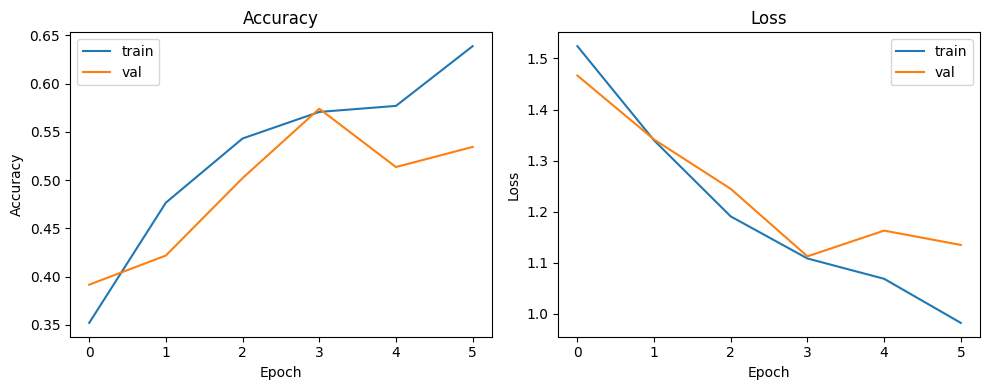

In [7]:
# ====== Plot training curves ======
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.tight_layout()
plt.show()

In [8]:
modelsFolder = "models"
os.makedirs(modelsFolder, exist_ok=True)
modelPath = os.path.join(modelsFolder, 'cnn_fe_600mwin_16c.h5')
model.save(modelPath)

print(f"Model saved at: {modelPath}")

Model saved at: models\cnn_fe_600mwin_16c.h5


In [9]:
# Freeze CNN & extract features

for layer in cnn.layers:
    layer.trainable = False

def extract_features(file_list):
    feats, labels = [], []
    for fpath in file_list:
        d = np.load(fpath, allow_pickle=True)
        for key_name in ['forearmData','wristData']:
            if key_name not in d: continue
            dd = d[key_name].item()
            for k, trial in dd.items():
                g = int(k[0])
                if g not in GESTURE_IDS or trial.shape[0] < WINDOW_SIZE: continue
                for win in sliding_windows_from_trial(trial):
                    if win.shape[1]==12:
                        tmp = np.zeros((WINDOW_SIZE,16),dtype=np.float32)
                        tmp[:,:12]=win; win=tmp
                    win = normalize_window(win)
                    feats.append(win); labels.append(GESTURE_MAP[g])
    if not feats: return np.empty((0,256),np.float32), np.empty((0,),np.int32)
    X = np.stack(feats); y = np.array(labels,np.int32)
    outs = [cnn.predict(X[i:i+128],verbose=0) for i in range(0,len(X),128)]
    return np.concatenate(outs), y

print("Extracting CNN features...")
train_feats, y_train = extract_features(train_files)
test_feats, y_test = extract_features(test_files)
print("Feature shapes:", train_feats.shape, test_feats.shape)

Extracting CNN features...
Feature shapes: (94500, 256) (22050, 256)


Accuracy : 0.6671201814058957
Precision: 0.6694261618143453
Recall   : 0.6671201814058956
F1-score : 0.6669412790324548

Classification report:
               precision    recall  f1-score   support

           0       0.66      0.72      0.69      4410
           1       0.62      0.70      0.66      4410
           2       0.63      0.57      0.60      4410
           3       0.79      0.73      0.76      4410
           4       0.65      0.62      0.64      4410

    accuracy                           0.67     22050
   macro avg       0.67      0.67      0.67     22050
weighted avg       0.67      0.67      0.67     22050



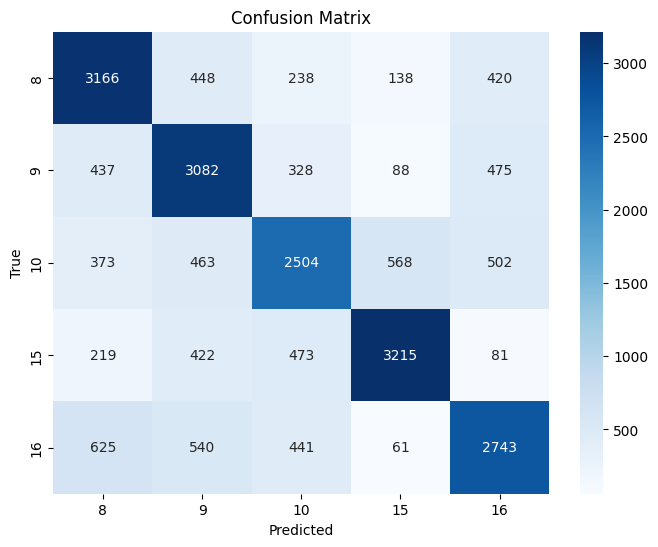

In [10]:
# Train & evaluate SVM

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_feats)
test_scaled = scaler.transform(test_feats)

svm = SVC(kernel='rbf', C=10, gamma='scale')
svm.fit(train_scaled, y_train)
y_pred = svm.predict(test_scaled)

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro', zero_division=0))
print("Recall   :", recall_score(y_test, y_pred, average='macro', zero_division=0))
print("F1-score :", f1_score(y_test, y_pred, average='macro', zero_division=0))
print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=GESTURE_IDS, yticklabels=GESTURE_IDS)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()

Visualizing feature space...


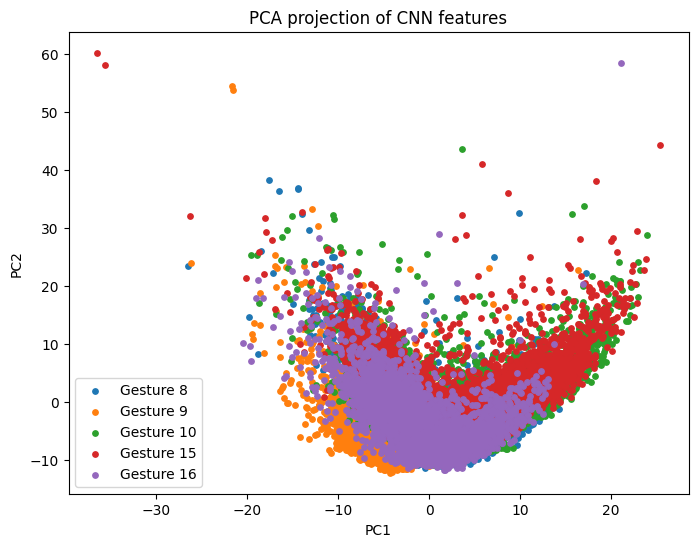

In [12]:
# 2D visualization of feature space
from sklearn.decomposition import PCA

print("Visualizing feature space...")
pca = PCA(n_components=2)
reduced = pca.fit_transform(test_scaled)
plt.figure(figsize=(8,6))
for lab in np.unique(y_test):
    plt.scatter(reduced[y_test==lab,0], reduced[y_test==lab,1], label=f"Gesture {GESTURE_IDS[lab]}", s=15)
plt.legend(); plt.title("PCA projection of CNN features")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()